In [38]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import cv2
from scipy.stats import multivariate_normal

In [39]:
def media(I):
    ch = I.shape[2]
    med=np.zeros(ch,)
    for i in range(ch):
        med[i]=np.mean(I[:,:,i].ravel())
    return med

In [40]:
def mcov(I):
    nx,ny,ch = I.shape
    It=np.zeros((ch,nx*ny))
    for i in range(ch):
        It[i,:]=I[:,:,i].ravel()
    cova=np.cov(It)
    return cova

In [41]:
def mcovi(I,sx,sy):
    I=I.astype(np.float)
    nx,ny,ch = I.shape
    It=np.zeros((ch,len(sx)))
    for i in range(ch):
        It[i,:]=I[sx,sy,i].ravel()
    cova=np.cov(It)
    return cova

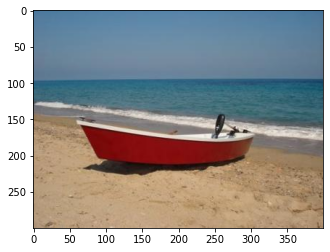

In [51]:
I = cv2.imread('im25.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
plt.imshow(I,cmap='gray')
nx,ny,ch = I.shape

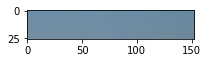

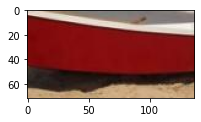

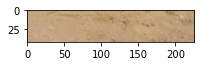

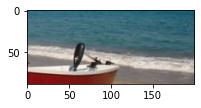

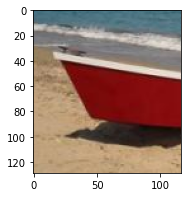

In [52]:
nm=5
phi=np.ones([nm,])/nm
med=np.zeros((nm,ch))
mc=np.zeros((nm,ch,ch))
for i in range(nm):
    roi=cv2.selectROI('sel',I)
    cv2.destroyWindow('sel')
    Iroi=I[int(roi[1]):int(roi[1]+roi[3]),int(roi[0]):int(roi[0]+roi[2]),:]
    fig=plt.figure(figsize = (3,3))
    plt.imshow(Iroi)
    med[i,:]=media(Iroi)
    mc[i,:,:]=mcov(Iroi)
medr=med 
mcovr=mcov


[[110.87757667 140.20437406 162.56636501]
 [130.53629359  63.5061841   56.70863747]
 [190.55669891 159.14889895 122.39277629]
 [103.46846591 118.45642045 122.85221591]
 [140.99476579 107.68177301  95.26237329]]
___________
[[106.26453984 136.66188801 160.97024075]
 [135.84781154  75.99883285  64.84325   ]
 [183.89946482 153.11271671 117.9668304 ]
 [ 95.65325015 119.9238466  129.95138744]
 [111.93931052 124.25266517 135.03253947]]
___________
[[103.61840698 134.98811066 160.07047072]
 [126.84634706  54.57760668  47.31313787]
 [180.28799335 149.98808547 115.69578724]
 [ 91.83566902 118.40844043 128.51336207]
 [105.91775436 128.73684126 146.65932185]]
___________
[[102.10939904 133.87791042 159.30954891]
 [126.93508992  55.7350821   48.60278725]
 [179.36551592 149.16795887 115.10033397]
 [ 93.09352651 118.84793359 128.39741171]
 [102.3122707  129.20277084 150.66278706]]
___________


C:\Users\coyul\AppData\Local\Temp/ipykernel_18892/3257234808.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I=I.astype(np.float)


[[101.97148891 133.68592659 159.14075951]
 [127.20927427  56.79353449  49.71781597]
 [179.05791394 148.90547989 114.95596633]
 [ 96.88249448 120.14515633 128.6057542 ]
 [ 95.48378122 128.74797981 155.13857962]]
___________
[[102.81199223 133.98402805 159.07136405]
 [126.77072718  55.3220637   48.27024609]
 [179.1166518  148.95477477 114.97754747]
 [ 99.26934904 120.88536983 128.66746684]
 [ 90.10925329 127.35826866 156.80638513]]
___________
[[102.95254726 133.82271944 158.64045475]
 [126.36175128  53.94743184  46.89734154]
 [179.16427255 148.99548325 114.99924645]
 [ 99.72310709 120.85540256 128.4539959 ]
 [ 88.36383997 126.87929812 157.33236415]]
___________
[[102.45183215 133.36013139 158.17541828]
 [126.15939137  53.18060822  46.16301739]
 [179.16803023 148.99876234 115.00174555]
 [ 99.91226823 120.82668235 128.33129386]
 [ 87.80124217 127.08292434 158.15914895]]
___________
[[101.89871591 132.81741544 157.61026148]
 [126.05013674  52.75699988  45.777762  ]
 [179.16586664 148.99704

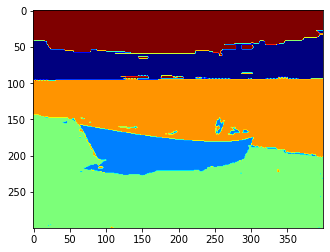

In [53]:
med=medr  
mcov=mcovr
print(med)
print("___________")

lon=nx*ny
pdf=np.zeros((nm,lon))             
It=np.zeros((lon,ch))
for i in range(ch):
    It[:,i]=I[:,:,i].ravel()
It=It.astype(float)
pdf=np.zeros((lon,nm))

for ite in range(30):
    for model in range(nm):
        pdf[:,model]=phi[model]*multivariate_normal.pdf(It[:,:], mean=med[model,:] , cov=mc[model,:,:]) 
    pdf=np.nan_to_num(pdf)
    pdft=np.sum(pdf,axis=1)
    gamma=pdf.T/pdft
    gamma=np.nan_to_num(gamma)
    
    for model in range(nm):
        temp=np.reshape(gamma[model,:],(nx,ny))
        gamma[model,:]=cv2.blur(temp,(30, 30)).ravel()
        #gamma[model,:]=cv2.GaussianBlur(temp,(15,15),cv2.BORDER_DEFAULT).ravel()
    assign=np.argmax(gamma,axis=0)
    for model in range(nm):
        suma=np.sum(gamma[model,:])
        phi[model]=suma/lon
        classt=np.where(assign==model)
        classt=classt[0]
        sx,sy=np.unravel_index(classt, (nx,ny))
        for i in range(ch):
            med[model,i]=np.dot(gamma[model,:],It[:,i])/suma
        mc[model,:,:]=mcovi(I,sx,sy)
    print(med)
    print("___________")
for model in range(nm):
    pdf[:,model]=phi[model]*multivariate_normal.pdf(It[:,:], mean=med[model,:] , cov=mc[model,:,:]) 
pdf=np.nan_to_num(pdf)
pdft=np.sum(pdf,axis=1)
gamma=pdf.T/pdft
gamma=np.nan_to_num(gamma)
for j in range(nm):
    temp=np.reshape(gamma[model,:],(nx,ny))
    gamma[model,:]=cv2.blur(temp,(3,3)).ravel()
assign=np.argmax(gamma,axis=0)
assign=np.reshape(assign,(nx,ny))
plt.imshow(assign,cmap='jet')
plt.show
print(gamma.shape)

[126.00003921  52.54668563  45.5863147 ]


<function matplotlib.pyplot.show(close=None, block=None)>

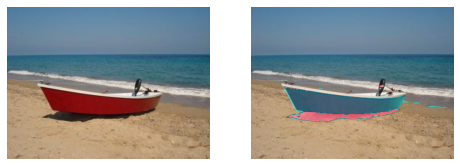

In [46]:
change=0
print(med[change,:])
temp=cv2.blur(gamma[change,:],(15,15))
gamma[change,:]=np.reshape(temp,(len(temp),))


assign=np.argmax(gamma,axis=0)
classt=np.where(assign==change)
classt=classt[0]
sx,sy=np.unravel_index(classt, (nx,ny))
It=np.copy(I)
for i in range(len(sx)):
    It[sx[i],sy[i],0]=It[sx[i],sy[i],0]-70
    It[sx[i],sy[i],1]=It[sx[i],sy[i],1]+80
    It[sx[i],sy[i],2]=It[sx[i],sy[i],2]+100
fig1=plt.figure(figsize = (8,8))
a = fig1.add_subplot(1, 2, 1)
plt.imshow(I, cmap='gray',vmin=0,vmax=255)
plt.axis('off');

b = fig1.add_subplot(1, 2, 2)
plt.imshow(I, cmap='gray',vmin=0,vmax=255)
plt.axis('off');
plt.imshow(It,cmap='gray')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

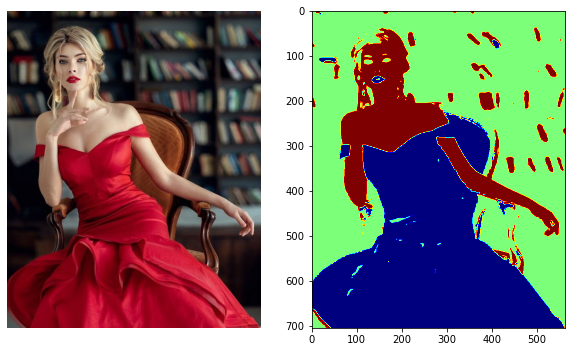

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(I, cmap='gray',vmin=0,vmax=255)
ax[0].axis('off')

Irt=np.argmax(gamma,axis=0)
Irt=np.reshape(Irt, (nx, ny))   
ax[1].imshow(Irt,cmap='jet')
plt.show

In [29]:

print(temp.shape)

(397620, 1)
